# Load data

In [1]:
from utils.prepare_data import getMonitoredPatients

patients = getMonitoredPatients()

In [2]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [3]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Define model

In [4]:
import xgboost as xgb

how = "last"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## Without validate

### Without fill missing data (BEST)

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:27:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:27:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/env

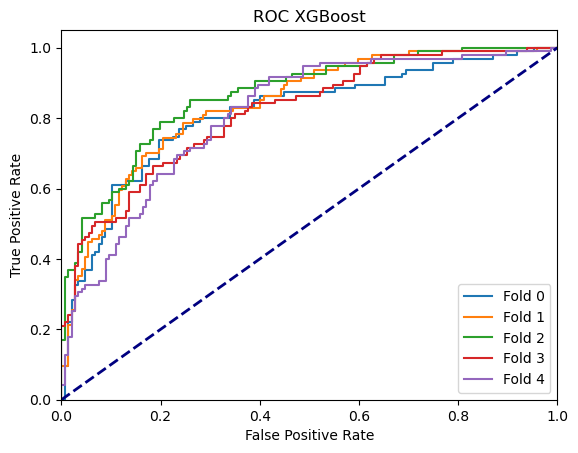

In [5]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from utils.prepare_data import normalizeData, trainTestPatients
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import pandas as pd


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

plt.figure()
for i, (trainPatients, testPatients) in enumerate(trainTestPatients(patients)):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))
    auc_pr_list.append(auc(recall_vals, precision_vals))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"Fold {i}")
    
bestModel = model
bestModelTest = X_test

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC XGBoost")
plt.legend(loc="lower right")
plt.show()

In [6]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8278492458819112 +- 0.019861509964791857 [np.float64(0.8128177586824203), np.float64(0.8377478651034882), np.float64(0.862364816149964), np.float64(0.8167267483777938), np.float64(0.8095890410958905)]
Accuracy: 0.7520661157024794 +- 0.014577108148174504 [0.7603305785123967, 0.7634854771784232, 0.7676348547717843, 0.7344398340248963, 0.7344398340248963]
Specificity: 0.8360916969527536 +- 0.03133710889194877 [np.float64(0.8503401360544217), np.float64(0.8027210884353742), np.float64(0.863013698630137), np.float64(0.8698630136986302), np.float64(0.7945205479452054)]
Precision: 0.7129869396721447 +- 0.02709826515320617 [0.7283950617283951, 0.6947368421052632, 0.7468354430379747, 0.7246376811594203, 0.6703296703296703]
Recall: 0.6225307950727883 +- 0.05653409215045079 [0.6210526315789474, 0.7021276595744681, 0.6210526315789474, 0.5263157894736842, 0.6421052631578947]
AUC PR: 0.7634522521835392 +- 0.035083956126559374 [np.float64(0.7311725980506187), np.float64(0.768733657612679), np.

### Fill missing with knn

In [7]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTestPatients(patients):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:28:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:29:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/cor

In [8]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8105262448288769
Average Accuracy: 0.7388052535921265
Average Precision: 0.6931125219130114
Average Recall: 0.6097648376259799


## With validate

### Without fill missing data

In [9]:
from utils.prepare_data import normalizeData, trainValTestPatients


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainValGen, testPatients in trainValTestPatients(patients):
    for trainPatients, valPatients in trainValGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
        y_val = dfVal[labelColumn]  # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        model = createModel()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

        accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
        precision_score_list_val.append(precision_score(y_test, y_pred))
        recall_score_list_val.append(recall_score(y_test, y_pred))
        auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66826
[1]	validation_0-logloss:0.66548
[2]	validation_0-logloss:0.66337
[3]	validation_0-logloss:0.66160
[4]	validation_0-logloss:0.65911
[5]	validation_0-logloss:0.65744
[6]	validation_0-logloss:0.65506
[7]	validation_0-logloss:0.65311
[8]	validation_0-logloss:0.65058
[9]	validation_0-logloss:0.64819
[10]	validation_0-logloss:0.64629
[11]	validation_0-logloss:0.64413
[12]	validation_0-logloss:0.64231
[13]	validation_0-logloss:0.64039
[14]	validation_0-logloss:0.63931
[15]	validation_0-logloss:0.63713
[16]	validation_0-logloss:0.63565
[17]	validation_0-logloss:0.63404
[18]	validation_0-logloss:0.63154
[19]	validation_0-logloss:0.63003
[20]	validation_0-logloss:0.62845
[21]	validation_0-logloss:0.62687
[22]	validation_0-logloss:0.62612
[23]	validation_0-logloss:0.62421
[24]	validation_0-logloss:0.62200
[25]	validation_0-logloss:0.62008
[26]	validation_0-logloss:0.61860
[27]	validation_0-logloss:0.61682
[28]	validation_0-logloss:0.61540


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:30:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-logloss:0.61406
[30]	validation_0-logloss:0.61241
[31]	validation_0-logloss:0.61069
[32]	validation_0-logloss:0.60911
[33]	validation_0-logloss:0.60777
[34]	validation_0-logloss:0.60630
[35]	validation_0-logloss:0.60516
[36]	validation_0-logloss:0.60366
[37]	validation_0-logloss:0.60244
[38]	validation_0-logloss:0.60132
[39]	validation_0-logloss:0.60031
[40]	validation_0-logloss:0.59918
[41]	validation_0-logloss:0.59850
[42]	validation_0-logloss:0.59726
[43]	validation_0-logloss:0.59608
[44]	validation_0-logloss:0.59563
[45]	validation_0-logloss:0.59469
[46]	validation_0-logloss:0.59364
[47]	validation_0-logloss:0.59253
[48]	validation_0-logloss:0.59173
[49]	validation_0-logloss:0.59108
[50]	validation_0-logloss:0.59001
[51]	validation_0-logloss:0.58936
[52]	validation_0-logloss:0.58837
[53]	validation_0-logloss:0.58726
[54]	validation_0-logloss:0.58684
[55]	validation_0-logloss:0.58572
[56]	validation_0-logloss:0.58495
[57]	validation_0-logloss:0.58413
[58]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:31:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.63547
[14]	validation_0-logloss:0.63370
[15]	validation_0-logloss:0.63157
[16]	validation_0-logloss:0.62941
[17]	validation_0-logloss:0.62746
[18]	validation_0-logloss:0.62512
[19]	validation_0-logloss:0.62339
[20]	validation_0-logloss:0.62138
[21]	validation_0-logloss:0.61909
[22]	validation_0-logloss:0.61718
[23]	validation_0-logloss:0.61503
[24]	validation_0-logloss:0.61322
[25]	validation_0-logloss:0.61126
[26]	validation_0-logloss:0.60950
[27]	validation_0-logloss:0.60736
[28]	validation_0-logloss:0.60555
[29]	validation_0-logloss:0.60409
[30]	validation_0-logloss:0.60215
[31]	validation_0-logloss:0.60018
[32]	validation_0-logloss:0.59897
[33]	validation_0-logloss:0.59766
[34]	validation_0-logloss:0.59602
[35]	validation_0-logloss:0.59462
[36]	validation_0-logloss:0.59303
[37]	validation_0-logloss:0.59147
[38]	validation_0-logloss:0.58978
[39]	validation_0-logloss:0.58823
[40]	validation_0-logloss:0.58640
[41]	validation_0-logloss:0.58488
[42]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:32:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-logloss:0.55514
[56]	validation_0-logloss:0.55325
[57]	validation_0-logloss:0.55193
[58]	validation_0-logloss:0.55139
[59]	validation_0-logloss:0.55034
[60]	validation_0-logloss:0.54890
[61]	validation_0-logloss:0.54767
[62]	validation_0-logloss:0.54616
[63]	validation_0-logloss:0.54509
[64]	validation_0-logloss:0.54367
[65]	validation_0-logloss:0.54278
[66]	validation_0-logloss:0.54177
[67]	validation_0-logloss:0.54048
[68]	validation_0-logloss:0.53942
[69]	validation_0-logloss:0.53780
[70]	validation_0-logloss:0.53640
[71]	validation_0-logloss:0.53535
[72]	validation_0-logloss:0.53467
[73]	validation_0-logloss:0.53336
[74]	validation_0-logloss:0.53186
[75]	validation_0-logloss:0.53090
[76]	validation_0-logloss:0.53026
[77]	validation_0-logloss:0.52902
[78]	validation_0-logloss:0.52778
[79]	validation_0-logloss:0.52670
[80]	validation_0-logloss:0.52575
[81]	validation_0-logloss:0.52482
[82]	validation_0-logloss:0.52397
[83]	validation_0-logloss:0.52364
[84]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:33:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.62407
[19]	validation_0-logloss:0.62264
[20]	validation_0-logloss:0.62033
[21]	validation_0-logloss:0.61863
[22]	validation_0-logloss:0.61748
[23]	validation_0-logloss:0.61527
[24]	validation_0-logloss:0.61358
[25]	validation_0-logloss:0.61185
[26]	validation_0-logloss:0.61094
[27]	validation_0-logloss:0.60888
[28]	validation_0-logloss:0.60679
[29]	validation_0-logloss:0.60466
[30]	validation_0-logloss:0.60290
[31]	validation_0-logloss:0.60136
[32]	validation_0-logloss:0.60087
[33]	validation_0-logloss:0.59887
[34]	validation_0-logloss:0.59759
[35]	validation_0-logloss:0.59585
[36]	validation_0-logloss:0.59428
[37]	validation_0-logloss:0.59322
[38]	validation_0-logloss:0.59164
[39]	validation_0-logloss:0.59094
[40]	validation_0-logloss:0.58940
[41]	validation_0-logloss:0.58810
[42]	validation_0-logloss:0.58656
[43]	validation_0-logloss:0.58465
[44]	validation_0-logloss:0.58284
[45]	validation_0-logloss:0.58118
[46]	validation_0-logloss:0.58016
[47]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:33:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[65]	validation_0-logloss:0.55608
[66]	validation_0-logloss:0.55511
[67]	validation_0-logloss:0.55363
[68]	validation_0-logloss:0.55261
[69]	validation_0-logloss:0.55152
[70]	validation_0-logloss:0.55039
[71]	validation_0-logloss:0.54900
[72]	validation_0-logloss:0.54815
[73]	validation_0-logloss:0.54718
[74]	validation_0-logloss:0.54611
[75]	validation_0-logloss:0.54510
[76]	validation_0-logloss:0.54410
[77]	validation_0-logloss:0.54300
[78]	validation_0-logloss:0.54236
[79]	validation_0-logloss:0.54139
[80]	validation_0-logloss:0.54034
[81]	validation_0-logloss:0.53980
[82]	validation_0-logloss:0.53897
[83]	validation_0-logloss:0.53792
[84]	validation_0-logloss:0.53699
[85]	validation_0-logloss:0.53563
[86]	validation_0-logloss:0.53476
[87]	validation_0-logloss:0.53384
[88]	validation_0-logloss:0.53336
[89]	validation_0-logloss:0.53237
[90]	validation_0-logloss:0.53195
[91]	validation_0-logloss:0.53161
[92]	validation_0-logloss:0.53100
[93]	validation_0-logloss:0.53022
[94]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:34:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[69]	validation_0-logloss:0.58433
[70]	validation_0-logloss:0.58357
[71]	validation_0-logloss:0.58294
[72]	validation_0-logloss:0.58267
[73]	validation_0-logloss:0.58171
[74]	validation_0-logloss:0.58106
[75]	validation_0-logloss:0.58034
[76]	validation_0-logloss:0.58021
[77]	validation_0-logloss:0.57962
[78]	validation_0-logloss:0.57926
[79]	validation_0-logloss:0.57915
[80]	validation_0-logloss:0.57870
[81]	validation_0-logloss:0.57813
[82]	validation_0-logloss:0.57764
[83]	validation_0-logloss:0.57725
[84]	validation_0-logloss:0.57671
[85]	validation_0-logloss:0.57607
[86]	validation_0-logloss:0.57592
[87]	validation_0-logloss:0.57540
[88]	validation_0-logloss:0.57487
[89]	validation_0-logloss:0.57412
[90]	validation_0-logloss:0.57417
[91]	validation_0-logloss:0.57399
[92]	validation_0-logloss:0.57377
[93]	validation_0-logloss:0.57327
[94]	validation_0-logloss:0.57302
[95]	validation_0-logloss:0.57244
[96]	validation_0-logloss:0.57206
[97]	validation_0-logloss:0.57138
[98]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:34:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.53472
[72]	validation_0-logloss:0.53349
[73]	validation_0-logloss:0.53244
[74]	validation_0-logloss:0.53088
[75]	validation_0-logloss:0.53006
[76]	validation_0-logloss:0.52933
[77]	validation_0-logloss:0.52854
[78]	validation_0-logloss:0.52719
[79]	validation_0-logloss:0.52619
[80]	validation_0-logloss:0.52527
[81]	validation_0-logloss:0.52414
[82]	validation_0-logloss:0.52280
[83]	validation_0-logloss:0.52220
[84]	validation_0-logloss:0.52116
[85]	validation_0-logloss:0.52011
[86]	validation_0-logloss:0.51947
[87]	validation_0-logloss:0.51847
[88]	validation_0-logloss:0.51757
[89]	validation_0-logloss:0.51672
[90]	validation_0-logloss:0.51573
[91]	validation_0-logloss:0.51491
[92]	validation_0-logloss:0.51397
[93]	validation_0-logloss:0.51288
[94]	validation_0-logloss:0.51220
[95]	validation_0-logloss:0.51165
[96]	validation_0-logloss:0.51050
[97]	validation_0-logloss:0.50939
[98]	validation_0-logloss:0.50874
[99]	validation_0-logloss:0.50802
[100]	validati

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:34:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.57094
[72]	validation_0-logloss:0.57034
[73]	validation_0-logloss:0.56919
[74]	validation_0-logloss:0.56942
[75]	validation_0-logloss:0.56884
[76]	validation_0-logloss:0.56816
[77]	validation_0-logloss:0.56734
[78]	validation_0-logloss:0.56665
[79]	validation_0-logloss:0.56555
[80]	validation_0-logloss:0.56451
[81]	validation_0-logloss:0.56409
[82]	validation_0-logloss:0.56337
[83]	validation_0-logloss:0.56298
[84]	validation_0-logloss:0.56231
[85]	validation_0-logloss:0.56213
[86]	validation_0-logloss:0.56185
[87]	validation_0-logloss:0.56141
[88]	validation_0-logloss:0.56071
[89]	validation_0-logloss:0.56026
[90]	validation_0-logloss:0.55910
[91]	validation_0-logloss:0.55887
[92]	validation_0-logloss:0.55828
[93]	validation_0-logloss:0.55804
[94]	validation_0-logloss:0.55777
[95]	validation_0-logloss:0.55705
[96]	validation_0-logloss:0.55656
[97]	validation_0-logloss:0.55592
[98]	validation_0-logloss:0.55533
[99]	validation_0-logloss:0.55488
[100]	validati

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:34:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[73]	validation_0-logloss:0.57746
[74]	validation_0-logloss:0.57661
[75]	validation_0-logloss:0.57600
[76]	validation_0-logloss:0.57498
[77]	validation_0-logloss:0.57475
[78]	validation_0-logloss:0.57445
[79]	validation_0-logloss:0.57381
[80]	validation_0-logloss:0.57300
[81]	validation_0-logloss:0.57238
[82]	validation_0-logloss:0.57186
[83]	validation_0-logloss:0.57132
[84]	validation_0-logloss:0.57107
[85]	validation_0-logloss:0.57099
[86]	validation_0-logloss:0.57058
[87]	validation_0-logloss:0.57024
[88]	validation_0-logloss:0.57001
[89]	validation_0-logloss:0.56963
[90]	validation_0-logloss:0.56895
[91]	validation_0-logloss:0.56862
[92]	validation_0-logloss:0.56814
[93]	validation_0-logloss:0.56770
[94]	validation_0-logloss:0.56725
[95]	validation_0-logloss:0.56700
[96]	validation_0-logloss:0.56630
[97]	validation_0-logloss:0.56592
[98]	validation_0-logloss:0.56523
[99]	validation_0-logloss:0.56493
[100]	validation_0-logloss:0.56436
[101]	validation_0-logloss:0.56424
[102]	valida

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:35:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-logloss:0.55776
[73]	validation_0-logloss:0.55720
[74]	validation_0-logloss:0.55631
[75]	validation_0-logloss:0.55539
[76]	validation_0-logloss:0.55472
[77]	validation_0-logloss:0.55377
[78]	validation_0-logloss:0.55285
[79]	validation_0-logloss:0.55245
[80]	validation_0-logloss:0.55175
[81]	validation_0-logloss:0.55074
[82]	validation_0-logloss:0.54978
[83]	validation_0-logloss:0.54914
[84]	validation_0-logloss:0.54811
[85]	validation_0-logloss:0.54736
[86]	validation_0-logloss:0.54662
[87]	validation_0-logloss:0.54584
[88]	validation_0-logloss:0.54515
[89]	validation_0-logloss:0.54406
[90]	validation_0-logloss:0.54313
[91]	validation_0-logloss:0.54218
[92]	validation_0-logloss:0.54186
[93]	validation_0-logloss:0.54099
[94]	validation_0-logloss:0.54001
[95]	validation_0-logloss:0.53953
[96]	validation_0-logloss:0.53878
[97]	validation_0-logloss:0.53829
[98]	validation_0-logloss:0.53734
[99]	validation_0-logloss:0.53657
[100]	validation_0-logloss:0.53612
[101]	validat

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-logloss:0.58117
[73]	validation_0-logloss:0.58077
[74]	validation_0-logloss:0.58004
[75]	validation_0-logloss:0.57894
[76]	validation_0-logloss:0.57861
[77]	validation_0-logloss:0.57769
[78]	validation_0-logloss:0.57731
[79]	validation_0-logloss:0.57711
[80]	validation_0-logloss:0.57639
[81]	validation_0-logloss:0.57609
[82]	validation_0-logloss:0.57573
[83]	validation_0-logloss:0.57561
[84]	validation_0-logloss:0.57482
[85]	validation_0-logloss:0.57390
[86]	validation_0-logloss:0.57303
[87]	validation_0-logloss:0.57278
[88]	validation_0-logloss:0.57218
[89]	validation_0-logloss:0.57144
[90]	validation_0-logloss:0.57099
[91]	validation_0-logloss:0.57058
[92]	validation_0-logloss:0.57018
[93]	validation_0-logloss:0.56983
[94]	validation_0-logloss:0.56911
[95]	validation_0-logloss:0.56885
[96]	validation_0-logloss:0.56835
[97]	validation_0-logloss:0.56725
[98]	validation_0-logloss:0.56657
[99]	validation_0-logloss:0.56605
[100]	validation_0-logloss:0.56602
[101]	validat

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:35:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation_0-logloss:0.59097
[43]	validation_0-logloss:0.58966
[44]	validation_0-logloss:0.58872
[45]	validation_0-logloss:0.58709
[46]	validation_0-logloss:0.58577
[47]	validation_0-logloss:0.58465
[48]	validation_0-logloss:0.58369
[49]	validation_0-logloss:0.58212
[50]	validation_0-logloss:0.58122
[51]	validation_0-logloss:0.57990
[52]	validation_0-logloss:0.57885
[53]	validation_0-logloss:0.57784
[54]	validation_0-logloss:0.57639
[55]	validation_0-logloss:0.57535
[56]	validation_0-logloss:0.57417
[57]	validation_0-logloss:0.57271
[58]	validation_0-logloss:0.57157
[59]	validation_0-logloss:0.57066
[60]	validation_0-logloss:0.56991
[61]	validation_0-logloss:0.56904
[62]	validation_0-logloss:0.56780
[63]	validation_0-logloss:0.56666
[64]	validation_0-logloss:0.56605
[65]	validation_0-logloss:0.56520
[66]	validation_0-logloss:0.56450
[67]	validation_0-logloss:0.56369
[68]	validation_0-logloss:0.56287
[69]	validation_0-logloss:0.56194
[70]	validation_0-logloss:0.56105
[71]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:35:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[73]	validation_0-logloss:0.55805
[74]	validation_0-logloss:0.55711
[75]	validation_0-logloss:0.55626
[76]	validation_0-logloss:0.55524
[77]	validation_0-logloss:0.55452
[78]	validation_0-logloss:0.55374
[79]	validation_0-logloss:0.55305
[80]	validation_0-logloss:0.55173
[81]	validation_0-logloss:0.55055
[82]	validation_0-logloss:0.54995
[83]	validation_0-logloss:0.54914
[84]	validation_0-logloss:0.54816
[85]	validation_0-logloss:0.54759
[86]	validation_0-logloss:0.54701
[87]	validation_0-logloss:0.54628
[88]	validation_0-logloss:0.54576
[89]	validation_0-logloss:0.54509
[90]	validation_0-logloss:0.54428
[91]	validation_0-logloss:0.54357
[92]	validation_0-logloss:0.54279
[93]	validation_0-logloss:0.54172
[94]	validation_0-logloss:0.54056
[95]	validation_0-logloss:0.54001
[96]	validation_0-logloss:0.53933
[97]	validation_0-logloss:0.53830
[98]	validation_0-logloss:0.53739
[99]	validation_0-logloss:0.53652
[100]	validation_0-logloss:0.53606
[101]	validation_0-logloss:0.53531
[102]	valida

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:36:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-logloss:0.62165
[24]	validation_0-logloss:0.61925
[25]	validation_0-logloss:0.61788
[26]	validation_0-logloss:0.61629
[27]	validation_0-logloss:0.61460
[28]	validation_0-logloss:0.61301
[29]	validation_0-logloss:0.61147
[30]	validation_0-logloss:0.61036
[31]	validation_0-logloss:0.60882
[32]	validation_0-logloss:0.60775
[33]	validation_0-logloss:0.60590
[34]	validation_0-logloss:0.60446
[35]	validation_0-logloss:0.60335
[36]	validation_0-logloss:0.60191
[37]	validation_0-logloss:0.60091
[38]	validation_0-logloss:0.59954
[39]	validation_0-logloss:0.59855
[40]	validation_0-logloss:0.59781
[41]	validation_0-logloss:0.59660
[42]	validation_0-logloss:0.59504
[43]	validation_0-logloss:0.59365
[44]	validation_0-logloss:0.59233
[45]	validation_0-logloss:0.59099
[46]	validation_0-logloss:0.58998
[47]	validation_0-logloss:0.58932
[48]	validation_0-logloss:0.58840
[49]	validation_0-logloss:0.58783
[50]	validation_0-logloss:0.58715
[51]	validation_0-logloss:0.58592
[52]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:37:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.63003
[21]	validation_0-logloss:0.62772
[22]	validation_0-logloss:0.62639
[23]	validation_0-logloss:0.62535
[24]	validation_0-logloss:0.62332
[25]	validation_0-logloss:0.62150
[26]	validation_0-logloss:0.62002
[27]	validation_0-logloss:0.61795
[28]	validation_0-logloss:0.61629
[29]	validation_0-logloss:0.61451
[30]	validation_0-logloss:0.61311
[31]	validation_0-logloss:0.61149
[32]	validation_0-logloss:0.60992
[33]	validation_0-logloss:0.60863
[34]	validation_0-logloss:0.60753
[35]	validation_0-logloss:0.60565
[36]	validation_0-logloss:0.60370
[37]	validation_0-logloss:0.60231
[38]	validation_0-logloss:0.60131
[39]	validation_0-logloss:0.60012
[40]	validation_0-logloss:0.59844
[41]	validation_0-logloss:0.59659
[42]	validation_0-logloss:0.59537
[43]	validation_0-logloss:0.59420
[44]	validation_0-logloss:0.59279
[45]	validation_0-logloss:0.59154
[46]	validation_0-logloss:0.59049
[47]	validation_0-logloss:0.58921
[48]	validation_0-logloss:0.58797
[49]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:38:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-logloss:0.59994
[39]	validation_0-logloss:0.59869
[40]	validation_0-logloss:0.59727
[41]	validation_0-logloss:0.59603
[42]	validation_0-logloss:0.59501
[43]	validation_0-logloss:0.59429
[44]	validation_0-logloss:0.59313
[45]	validation_0-logloss:0.59226
[46]	validation_0-logloss:0.59125
[47]	validation_0-logloss:0.59060
[48]	validation_0-logloss:0.59001
[49]	validation_0-logloss:0.58900
[50]	validation_0-logloss:0.58833
[51]	validation_0-logloss:0.58736
[52]	validation_0-logloss:0.58612
[53]	validation_0-logloss:0.58514
[54]	validation_0-logloss:0.58401
[55]	validation_0-logloss:0.58274
[56]	validation_0-logloss:0.58162
[57]	validation_0-logloss:0.58063
[58]	validation_0-logloss:0.57946
[59]	validation_0-logloss:0.57847
[60]	validation_0-logloss:0.57768
[61]	validation_0-logloss:0.57665
[62]	validation_0-logloss:0.57546
[63]	validation_0-logloss:0.57499
[64]	validation_0-logloss:0.57418
[65]	validation_0-logloss:0.57363
[66]	validation_0-logloss:0.57289
[67]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:38:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.62130
[18]	validation_0-logloss:0.61892
[19]	validation_0-logloss:0.61641
[20]	validation_0-logloss:0.61425
[21]	validation_0-logloss:0.61207
[22]	validation_0-logloss:0.60982
[23]	validation_0-logloss:0.60791
[24]	validation_0-logloss:0.60599
[25]	validation_0-logloss:0.60418
[26]	validation_0-logloss:0.60249
[27]	validation_0-logloss:0.59983
[28]	validation_0-logloss:0.59754
[29]	validation_0-logloss:0.59555
[30]	validation_0-logloss:0.59361
[31]	validation_0-logloss:0.59156
[32]	validation_0-logloss:0.59002
[33]	validation_0-logloss:0.58769
[34]	validation_0-logloss:0.58579
[35]	validation_0-logloss:0.58356
[36]	validation_0-logloss:0.58188
[37]	validation_0-logloss:0.58042
[38]	validation_0-logloss:0.57893
[39]	validation_0-logloss:0.57768
[40]	validation_0-logloss:0.57562
[41]	validation_0-logloss:0.57353
[42]	validation_0-logloss:0.57169
[43]	validation_0-logloss:0.56977
[44]	validation_0-logloss:0.56817
[45]	validation_0-logloss:0.56618
[46]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:39:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-logloss:0.61458
[26]	validation_0-logloss:0.61279
[27]	validation_0-logloss:0.61096
[28]	validation_0-logloss:0.60937
[29]	validation_0-logloss:0.60795
[30]	validation_0-logloss:0.60643
[31]	validation_0-logloss:0.60413
[32]	validation_0-logloss:0.60284
[33]	validation_0-logloss:0.60177
[34]	validation_0-logloss:0.60058
[35]	validation_0-logloss:0.59915
[36]	validation_0-logloss:0.59757
[37]	validation_0-logloss:0.59600
[38]	validation_0-logloss:0.59497
[39]	validation_0-logloss:0.59414
[40]	validation_0-logloss:0.59321
[41]	validation_0-logloss:0.59211
[42]	validation_0-logloss:0.59142
[43]	validation_0-logloss:0.58946
[44]	validation_0-logloss:0.58820
[45]	validation_0-logloss:0.58684
[46]	validation_0-logloss:0.58549
[47]	validation_0-logloss:0.58426
[48]	validation_0-logloss:0.58343
[49]	validation_0-logloss:0.58222
[50]	validation_0-logloss:0.58123
[51]	validation_0-logloss:0.58027
[52]	validation_0-logloss:0.57933
[53]	validation_0-logloss:0.57755
[54]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:40:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[66]	validation_0-logloss:0.55611
[67]	validation_0-logloss:0.55534
[68]	validation_0-logloss:0.55419
[69]	validation_0-logloss:0.55377
[70]	validation_0-logloss:0.55275
[71]	validation_0-logloss:0.55174
[72]	validation_0-logloss:0.55131
[73]	validation_0-logloss:0.55073
[74]	validation_0-logloss:0.55006
[75]	validation_0-logloss:0.54951
[76]	validation_0-logloss:0.54896
[77]	validation_0-logloss:0.54886
[78]	validation_0-logloss:0.54794
[79]	validation_0-logloss:0.54747
[80]	validation_0-logloss:0.54701
[81]	validation_0-logloss:0.54656
[82]	validation_0-logloss:0.54578
[83]	validation_0-logloss:0.54557
[84]	validation_0-logloss:0.54508
[85]	validation_0-logloss:0.54476
[86]	validation_0-logloss:0.54415
[87]	validation_0-logloss:0.54309
[88]	validation_0-logloss:0.54241
[89]	validation_0-logloss:0.54171
[90]	validation_0-logloss:0.54105
[91]	validation_0-logloss:0.54044
[92]	validation_0-logloss:0.53945
[93]	validation_0-logloss:0.53890
[94]	validation_0-logloss:0.53772
[95]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:40:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-logloss:0.56028
[73]	validation_0-logloss:0.55957
[74]	validation_0-logloss:0.55880
[75]	validation_0-logloss:0.55813
[76]	validation_0-logloss:0.55797
[77]	validation_0-logloss:0.55708
[78]	validation_0-logloss:0.55547
[79]	validation_0-logloss:0.55473
[80]	validation_0-logloss:0.55336
[81]	validation_0-logloss:0.55264
[82]	validation_0-logloss:0.55215
[83]	validation_0-logloss:0.55148
[84]	validation_0-logloss:0.55069
[85]	validation_0-logloss:0.54960
[86]	validation_0-logloss:0.54884
[87]	validation_0-logloss:0.54803
[88]	validation_0-logloss:0.54699
[89]	validation_0-logloss:0.54609
[90]	validation_0-logloss:0.54539
[91]	validation_0-logloss:0.54471
[92]	validation_0-logloss:0.54423
[93]	validation_0-logloss:0.54343
[94]	validation_0-logloss:0.54271
[95]	validation_0-logloss:0.54219
[96]	validation_0-logloss:0.54138
[97]	validation_0-logloss:0.54079
[98]	validation_0-logloss:0.54004
[99]	validation_0-logloss:0.53944
[100]	validation_0-logloss:0.53891
[101]	validat

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:40:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation_0-logloss:0.59978
[45]	validation_0-logloss:0.59868
[46]	validation_0-logloss:0.59808
[47]	validation_0-logloss:0.59730
[48]	validation_0-logloss:0.59632
[49]	validation_0-logloss:0.59560
[50]	validation_0-logloss:0.59488
[51]	validation_0-logloss:0.59428
[52]	validation_0-logloss:0.59316
[53]	validation_0-logloss:0.59241
[54]	validation_0-logloss:0.59190
[55]	validation_0-logloss:0.59097
[56]	validation_0-logloss:0.59022
[57]	validation_0-logloss:0.58916
[58]	validation_0-logloss:0.58805
[59]	validation_0-logloss:0.58776
[60]	validation_0-logloss:0.58728
[61]	validation_0-logloss:0.58627
[62]	validation_0-logloss:0.58582
[63]	validation_0-logloss:0.58527
[64]	validation_0-logloss:0.58497
[65]	validation_0-logloss:0.58477
[66]	validation_0-logloss:0.58454
[67]	validation_0-logloss:0.58347
[68]	validation_0-logloss:0.58275
[69]	validation_0-logloss:0.58229
[70]	validation_0-logloss:0.58188
[71]	validation_0-logloss:0.58139
[72]	validation_0-logloss:0.58065
[73]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:40:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[53]	validation_0-logloss:0.55074
[54]	validation_0-logloss:0.54918
[55]	validation_0-logloss:0.54750
[56]	validation_0-logloss:0.54635
[57]	validation_0-logloss:0.54486
[58]	validation_0-logloss:0.54317
[59]	validation_0-logloss:0.54187
[60]	validation_0-logloss:0.54070
[61]	validation_0-logloss:0.53945
[62]	validation_0-logloss:0.53782
[63]	validation_0-logloss:0.53624
[64]	validation_0-logloss:0.53478
[65]	validation_0-logloss:0.53323
[66]	validation_0-logloss:0.53234
[67]	validation_0-logloss:0.53155
[68]	validation_0-logloss:0.53018
[69]	validation_0-logloss:0.52858
[70]	validation_0-logloss:0.52749
[71]	validation_0-logloss:0.52633
[72]	validation_0-logloss:0.52485
[73]	validation_0-logloss:0.52382
[74]	validation_0-logloss:0.52246
[75]	validation_0-logloss:0.52113
[76]	validation_0-logloss:0.52052
[77]	validation_0-logloss:0.51967
[78]	validation_0-logloss:0.51842
[79]	validation_0-logloss:0.51748
[80]	validation_0-logloss:0.51614
[81]	validation_0-logloss:0.51453
[82]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:41:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[73]	validation_0-logloss:0.55125
[74]	validation_0-logloss:0.55050
[75]	validation_0-logloss:0.54976
[76]	validation_0-logloss:0.54881
[77]	validation_0-logloss:0.54828
[78]	validation_0-logloss:0.54735
[79]	validation_0-logloss:0.54644
[80]	validation_0-logloss:0.54531
[81]	validation_0-logloss:0.54444
[82]	validation_0-logloss:0.54340
[83]	validation_0-logloss:0.54237
[84]	validation_0-logloss:0.54149
[85]	validation_0-logloss:0.54062
[86]	validation_0-logloss:0.54017
[87]	validation_0-logloss:0.53957
[88]	validation_0-logloss:0.53885
[89]	validation_0-logloss:0.53822
[90]	validation_0-logloss:0.53735
[91]	validation_0-logloss:0.53686
[92]	validation_0-logloss:0.53608
[93]	validation_0-logloss:0.53512
[94]	validation_0-logloss:0.53435
[95]	validation_0-logloss:0.53373
[96]	validation_0-logloss:0.53298
[97]	validation_0-logloss:0.53216
[98]	validation_0-logloss:0.53142
[99]	validation_0-logloss:0.53068
[100]	validation_0-logloss:0.53042
[101]	validation_0-logloss:0.52984
[102]	valida

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:41:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-logloss:0.54969
[73]	validation_0-logloss:0.54911
[74]	validation_0-logloss:0.54795
[75]	validation_0-logloss:0.54719
[76]	validation_0-logloss:0.54629
[77]	validation_0-logloss:0.54582
[78]	validation_0-logloss:0.54517
[79]	validation_0-logloss:0.54466
[80]	validation_0-logloss:0.54416
[81]	validation_0-logloss:0.54287
[82]	validation_0-logloss:0.54194
[83]	validation_0-logloss:0.54155
[84]	validation_0-logloss:0.54034
[85]	validation_0-logloss:0.53926
[86]	validation_0-logloss:0.53870
[87]	validation_0-logloss:0.53863
[88]	validation_0-logloss:0.53814
[89]	validation_0-logloss:0.53730
[90]	validation_0-logloss:0.53680
[91]	validation_0-logloss:0.53640
[92]	validation_0-logloss:0.53544
[93]	validation_0-logloss:0.53482
[94]	validation_0-logloss:0.53412
[95]	validation_0-logloss:0.53339
[96]	validation_0-logloss:0.53270
[97]	validation_0-logloss:0.53243
[98]	validation_0-logloss:0.53144
[99]	validation_0-logloss:0.53079
[100]	validation_0-logloss:0.53014
[101]	validat

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:41:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.55519
[72]	validation_0-logloss:0.55382
[73]	validation_0-logloss:0.55334
[74]	validation_0-logloss:0.55283
[75]	validation_0-logloss:0.55214
[76]	validation_0-logloss:0.55162
[77]	validation_0-logloss:0.55106
[78]	validation_0-logloss:0.54978
[79]	validation_0-logloss:0.54903
[80]	validation_0-logloss:0.54812
[81]	validation_0-logloss:0.54702
[82]	validation_0-logloss:0.54620
[83]	validation_0-logloss:0.54557
[84]	validation_0-logloss:0.54501
[85]	validation_0-logloss:0.54431
[86]	validation_0-logloss:0.54410
[87]	validation_0-logloss:0.54305
[88]	validation_0-logloss:0.54241
[89]	validation_0-logloss:0.54147
[90]	validation_0-logloss:0.54095
[91]	validation_0-logloss:0.54028
[92]	validation_0-logloss:0.53974
[93]	validation_0-logloss:0.53896
[94]	validation_0-logloss:0.53872
[95]	validation_0-logloss:0.53798
[96]	validation_0-logloss:0.53732
[97]	validation_0-logloss:0.53664
[98]	validation_0-logloss:0.53595
[99]	validation_0-logloss:0.53513
[100]	validati

In [10]:
print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8198196265114216
Average Accuracy: 0.7482610335722368
Average Precision: 0.7176046870700165
Average Recall: 0.6017737961926092


### Fill missing with knn 

In [11]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainValGen, testPatients in trainValTestPatients(patients):
    for trainPatients, valPatients in trainValGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
        y_val = dfVal[labelColumn]  # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        model = createModel()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

        accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
        precision_score_list_val_knn.append(precision_score(y_test, y_pred))
        recall_score_list_val_knn.append(recall_score(y_test, y_pred))
        auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66836
[1]	validation_0-logloss:0.66594
[2]	validation_0-logloss:0.66373
[3]	validation_0-logloss:0.66156
[4]	validation_0-logloss:0.65910
[5]	validation_0-logloss:0.65653
[6]	validation_0-logloss:0.65495
[7]	validation_0-logloss:0.65339
[8]	validation_0-logloss:0.65082
[9]	validation_0-logloss:0.64851
[10]	validation_0-logloss:0.64679
[11]	validation_0-logloss:0.64524
[12]	validation_0-logloss:0.64303
[13]	validation_0-logloss:0.64097
[14]	validation_0-logloss:0.64034
[15]	validation_0-logloss:0.63862
[16]	validation_0-logloss:0.63705
[17]	validation_0-logloss:0.63581
[18]	validation_0-logloss:0.63361
[19]	validation_0-logloss:0.63180
[20]	validation_0-logloss:0.63061
[21]	validation_0-logloss:0.62876
[22]	validation_0-logloss:0.62780
[23]	validation_0-logloss:0.62610
[24]	validation_0-logloss:0.62512
[25]	validation_0-logloss:0.62364
[26]	validation_0-logloss:0.62197
[27]	validation_0-logloss:0.62005
[28]	validation_0-logloss:0.61862
[29]	validation_0-loglos

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:41:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[66]	validation_0-logloss:0.58239
[67]	validation_0-logloss:0.58165
[68]	validation_0-logloss:0.58102
[69]	validation_0-logloss:0.57983
[70]	validation_0-logloss:0.57949
[71]	validation_0-logloss:0.57913
[72]	validation_0-logloss:0.57815
[73]	validation_0-logloss:0.57804
[74]	validation_0-logloss:0.57730
[75]	validation_0-logloss:0.57691
[76]	validation_0-logloss:0.57644
[77]	validation_0-logloss:0.57617
[78]	validation_0-logloss:0.57601
[79]	validation_0-logloss:0.57585
[80]	validation_0-logloss:0.57552
[81]	validation_0-logloss:0.57524
[82]	validation_0-logloss:0.57490
[83]	validation_0-logloss:0.57430
[84]	validation_0-logloss:0.57349
[85]	validation_0-logloss:0.57307
[86]	validation_0-logloss:0.57256
[87]	validation_0-logloss:0.57176
[88]	validation_0-logloss:0.57124
[89]	validation_0-logloss:0.57113
[90]	validation_0-logloss:0.57075
[91]	validation_0-logloss:0.57032
[92]	validation_0-logloss:0.56990
[93]	validation_0-logloss:0.56984
[94]	validation_0-logloss:0.56947
[95]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:42:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-logloss:0.61009
[31]	validation_0-logloss:0.60838
[32]	validation_0-logloss:0.60681
[33]	validation_0-logloss:0.60527
[34]	validation_0-logloss:0.60406
[35]	validation_0-logloss:0.60274
[36]	validation_0-logloss:0.60159
[37]	validation_0-logloss:0.60013
[38]	validation_0-logloss:0.59888
[39]	validation_0-logloss:0.59758
[40]	validation_0-logloss:0.59633
[41]	validation_0-logloss:0.59561
[42]	validation_0-logloss:0.59397
[43]	validation_0-logloss:0.59280
[44]	validation_0-logloss:0.59177
[45]	validation_0-logloss:0.59042
[46]	validation_0-logloss:0.58901
[47]	validation_0-logloss:0.58827
[48]	validation_0-logloss:0.58723
[49]	validation_0-logloss:0.58622
[50]	validation_0-logloss:0.58512
[51]	validation_0-logloss:0.58406
[52]	validation_0-logloss:0.58295
[53]	validation_0-logloss:0.58190
[54]	validation_0-logloss:0.58110
[55]	validation_0-logloss:0.58011
[56]	validation_0-logloss:0.57868
[57]	validation_0-logloss:0.57776
[58]	validation_0-logloss:0.57694
[59]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:42:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-logloss:0.60738
[26]	validation_0-logloss:0.60510
[27]	validation_0-logloss:0.60329
[28]	validation_0-logloss:0.60150
[29]	validation_0-logloss:0.59965
[30]	validation_0-logloss:0.59760
[31]	validation_0-logloss:0.59614
[32]	validation_0-logloss:0.59461
[33]	validation_0-logloss:0.59294
[34]	validation_0-logloss:0.59081
[35]	validation_0-logloss:0.58904
[36]	validation_0-logloss:0.58716
[37]	validation_0-logloss:0.58510
[38]	validation_0-logloss:0.58392
[39]	validation_0-logloss:0.58232
[40]	validation_0-logloss:0.58065
[41]	validation_0-logloss:0.57881
[42]	validation_0-logloss:0.57767
[43]	validation_0-logloss:0.57563
[44]	validation_0-logloss:0.57346
[45]	validation_0-logloss:0.57217
[46]	validation_0-logloss:0.57043
[47]	validation_0-logloss:0.56894
[48]	validation_0-logloss:0.56784
[49]	validation_0-logloss:0.56648
[50]	validation_0-logloss:0.56519
[51]	validation_0-logloss:0.56398
[52]	validation_0-logloss:0.56295
[53]	validation_0-logloss:0.56147
[54]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.61393
[28]	validation_0-logloss:0.61208
[29]	validation_0-logloss:0.61031
[30]	validation_0-logloss:0.60922
[31]	validation_0-logloss:0.60825
[32]	validation_0-logloss:0.60714
[33]	validation_0-logloss:0.60586
[34]	validation_0-logloss:0.60485
[35]	validation_0-logloss:0.60359
[36]	validation_0-logloss:0.60226
[37]	validation_0-logloss:0.60080
[38]	validation_0-logloss:0.60004
[39]	validation_0-logloss:0.59899
[40]	validation_0-logloss:0.59805
[41]	validation_0-logloss:0.59642
[42]	validation_0-logloss:0.59601
[43]	validation_0-logloss:0.59487
[44]	validation_0-logloss:0.59364
[45]	validation_0-logloss:0.59277
[46]	validation_0-logloss:0.59164
[47]	validation_0-logloss:0.59012
[48]	validation_0-logloss:0.58869
[49]	validation_0-logloss:0.58753
[50]	validation_0-logloss:0.58647
[51]	validation_0-logloss:0.58558
[52]	validation_0-logloss:0.58445
[53]	validation_0-logloss:0.58376
[54]	validation_0-logloss:0.58334
[55]	validation_0-logloss:0.58221
[56]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:44:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-logloss:0.61961
[23]	validation_0-logloss:0.61769
[24]	validation_0-logloss:0.61625
[25]	validation_0-logloss:0.61463
[26]	validation_0-logloss:0.61299
[27]	validation_0-logloss:0.61149
[28]	validation_0-logloss:0.60983
[29]	validation_0-logloss:0.60810
[30]	validation_0-logloss:0.60663
[31]	validation_0-logloss:0.60470
[32]	validation_0-logloss:0.60374
[33]	validation_0-logloss:0.60240
[34]	validation_0-logloss:0.60109
[35]	validation_0-logloss:0.59979
[36]	validation_0-logloss:0.59812
[37]	validation_0-logloss:0.59635
[38]	validation_0-logloss:0.59498
[39]	validation_0-logloss:0.59380
[40]	validation_0-logloss:0.59279
[41]	validation_0-logloss:0.59176
[42]	validation_0-logloss:0.59057
[43]	validation_0-logloss:0.58903
[44]	validation_0-logloss:0.58788
[45]	validation_0-logloss:0.58667
[46]	validation_0-logloss:0.58548
[47]	validation_0-logloss:0.58427
[48]	validation_0-logloss:0.58349
[49]	validation_0-logloss:0.58234
[50]	validation_0-logloss:0.58099
[51]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:45:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation_0-logloss:0.60925
[45]	validation_0-logloss:0.60851
[46]	validation_0-logloss:0.60770
[47]	validation_0-logloss:0.60690
[48]	validation_0-logloss:0.60610
[49]	validation_0-logloss:0.60530
[50]	validation_0-logloss:0.60441
[51]	validation_0-logloss:0.60346
[52]	validation_0-logloss:0.60283
[53]	validation_0-logloss:0.60201
[54]	validation_0-logloss:0.60125
[55]	validation_0-logloss:0.60053
[56]	validation_0-logloss:0.59993
[57]	validation_0-logloss:0.59910
[58]	validation_0-logloss:0.59877
[59]	validation_0-logloss:0.59831
[60]	validation_0-logloss:0.59784
[61]	validation_0-logloss:0.59763
[62]	validation_0-logloss:0.59678
[63]	validation_0-logloss:0.59629
[64]	validation_0-logloss:0.59609
[65]	validation_0-logloss:0.59557
[66]	validation_0-logloss:0.59529
[67]	validation_0-logloss:0.59430
[68]	validation_0-logloss:0.59429
[69]	validation_0-logloss:0.59407
[70]	validation_0-logloss:0.59342
[71]	validation_0-logloss:0.59336
[72]	validation_0-logloss:0.59303
[73]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.63185
[16]	validation_0-logloss:0.62971
[17]	validation_0-logloss:0.62807
[18]	validation_0-logloss:0.62654
[19]	validation_0-logloss:0.62422
[20]	validation_0-logloss:0.62199
[21]	validation_0-logloss:0.61947
[22]	validation_0-logloss:0.61739
[23]	validation_0-logloss:0.61563
[24]	validation_0-logloss:0.61361
[25]	validation_0-logloss:0.61191
[26]	validation_0-logloss:0.61027
[27]	validation_0-logloss:0.60856
[28]	validation_0-logloss:0.60669
[29]	validation_0-logloss:0.60493
[30]	validation_0-logloss:0.60352
[31]	validation_0-logloss:0.60163
[32]	validation_0-logloss:0.60005
[33]	validation_0-logloss:0.59796
[34]	validation_0-logloss:0.59631
[35]	validation_0-logloss:0.59453
[36]	validation_0-logloss:0.59284
[37]	validation_0-logloss:0.59164
[38]	validation_0-logloss:0.58954
[39]	validation_0-logloss:0.58821
[40]	validation_0-logloss:0.58693
[41]	validation_0-logloss:0.58515
[42]	validation_0-logloss:0.58358
[43]	validation_0-logloss:0.58252
[44]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[61]	validation_0-logloss:0.58802
[62]	validation_0-logloss:0.58679
[63]	validation_0-logloss:0.58598
[64]	validation_0-logloss:0.58527
[65]	validation_0-logloss:0.58467
[66]	validation_0-logloss:0.58366
[67]	validation_0-logloss:0.58286
[68]	validation_0-logloss:0.58210
[69]	validation_0-logloss:0.58173
[70]	validation_0-logloss:0.58095
[71]	validation_0-logloss:0.58032
[72]	validation_0-logloss:0.57997
[73]	validation_0-logloss:0.57918
[74]	validation_0-logloss:0.57866
[75]	validation_0-logloss:0.57782
[76]	validation_0-logloss:0.57743
[77]	validation_0-logloss:0.57692
[78]	validation_0-logloss:0.57622
[79]	validation_0-logloss:0.57500
[80]	validation_0-logloss:0.57391
[81]	validation_0-logloss:0.57328
[82]	validation_0-logloss:0.57242
[83]	validation_0-logloss:0.57176
[84]	validation_0-logloss:0.57105
[85]	validation_0-logloss:0.57047
[86]	validation_0-logloss:0.57009
[87]	validation_0-logloss:0.56930
[88]	validation_0-logloss:0.56879
[89]	validation_0-logloss:0.56812
[90]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation_0-logloss:0.60508
[45]	validation_0-logloss:0.60398
[46]	validation_0-logloss:0.60316
[47]	validation_0-logloss:0.60228
[48]	validation_0-logloss:0.60157
[49]	validation_0-logloss:0.60072
[50]	validation_0-logloss:0.59967
[51]	validation_0-logloss:0.59904
[52]	validation_0-logloss:0.59763
[53]	validation_0-logloss:0.59725
[54]	validation_0-logloss:0.59653
[55]	validation_0-logloss:0.59579
[56]	validation_0-logloss:0.59509
[57]	validation_0-logloss:0.59453
[58]	validation_0-logloss:0.59403
[59]	validation_0-logloss:0.59384
[60]	validation_0-logloss:0.59284
[61]	validation_0-logloss:0.59229
[62]	validation_0-logloss:0.59175
[63]	validation_0-logloss:0.59089
[64]	validation_0-logloss:0.59069
[65]	validation_0-logloss:0.59038
[66]	validation_0-logloss:0.59005
[67]	validation_0-logloss:0.58925
[68]	validation_0-logloss:0.58823
[69]	validation_0-logloss:0.58800
[70]	validation_0-logloss:0.58742
[71]	validation_0-logloss:0.58733
[72]	validation_0-logloss:0.58666
[73]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:47:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-logloss:0.57516
[60]	validation_0-logloss:0.57414
[61]	validation_0-logloss:0.57287
[62]	validation_0-logloss:0.57159
[63]	validation_0-logloss:0.57068
[64]	validation_0-logloss:0.56957
[65]	validation_0-logloss:0.56856
[66]	validation_0-logloss:0.56758
[67]	validation_0-logloss:0.56685
[68]	validation_0-logloss:0.56640
[69]	validation_0-logloss:0.56557
[70]	validation_0-logloss:0.56482
[71]	validation_0-logloss:0.56389
[72]	validation_0-logloss:0.56273
[73]	validation_0-logloss:0.56172
[74]	validation_0-logloss:0.56076
[75]	validation_0-logloss:0.55968
[76]	validation_0-logloss:0.55888
[77]	validation_0-logloss:0.55774
[78]	validation_0-logloss:0.55697
[79]	validation_0-logloss:0.55654
[80]	validation_0-logloss:0.55576
[81]	validation_0-logloss:0.55505
[82]	validation_0-logloss:0.55398
[83]	validation_0-logloss:0.55355
[84]	validation_0-logloss:0.55266
[85]	validation_0-logloss:0.55224
[86]	validation_0-logloss:0.55176
[87]	validation_0-logloss:0.55117
[88]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:47:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation_0-logloss:0.60658
[50]	validation_0-logloss:0.60625
[51]	validation_0-logloss:0.60563
[52]	validation_0-logloss:0.60471
[53]	validation_0-logloss:0.60416
[54]	validation_0-logloss:0.60388
[55]	validation_0-logloss:0.60359
[56]	validation_0-logloss:0.60301
[57]	validation_0-logloss:0.60216
[58]	validation_0-logloss:0.60151
[59]	validation_0-logloss:0.60114
[60]	validation_0-logloss:0.60064
[61]	validation_0-logloss:0.59974
[62]	validation_0-logloss:0.59884
[63]	validation_0-logloss:0.59792
[64]	validation_0-logloss:0.59773
[65]	validation_0-logloss:0.59715
[66]	validation_0-logloss:0.59689
[67]	validation_0-logloss:0.59649
[68]	validation_0-logloss:0.59582
[69]	validation_0-logloss:0.59520
[70]	validation_0-logloss:0.59536
[71]	validation_0-logloss:0.59504
[72]	validation_0-logloss:0.59438
[73]	validation_0-logloss:0.59403
[74]	validation_0-logloss:0.59351
[75]	validation_0-logloss:0.59245
[76]	validation_0-logloss:0.59232
[77]	validation_0-logloss:0.59208
[78]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:47:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[61]	validation_0-logloss:0.58220
[62]	validation_0-logloss:0.58135
[63]	validation_0-logloss:0.57982
[64]	validation_0-logloss:0.57901
[65]	validation_0-logloss:0.57817
[66]	validation_0-logloss:0.57744
[67]	validation_0-logloss:0.57655
[68]	validation_0-logloss:0.57613
[69]	validation_0-logloss:0.57507
[70]	validation_0-logloss:0.57433
[71]	validation_0-logloss:0.57363
[72]	validation_0-logloss:0.57289
[73]	validation_0-logloss:0.57221
[74]	validation_0-logloss:0.57135
[75]	validation_0-logloss:0.57069
[76]	validation_0-logloss:0.57017
[77]	validation_0-logloss:0.56958
[78]	validation_0-logloss:0.56922
[79]	validation_0-logloss:0.56849
[80]	validation_0-logloss:0.56798
[81]	validation_0-logloss:0.56700
[82]	validation_0-logloss:0.56619
[83]	validation_0-logloss:0.56582
[84]	validation_0-logloss:0.56521
[85]	validation_0-logloss:0.56462
[86]	validation_0-logloss:0.56365
[87]	validation_0-logloss:0.56341
[88]	validation_0-logloss:0.56301
[89]	validation_0-logloss:0.56274
[90]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:47:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[57]	validation_0-logloss:0.57081
[58]	validation_0-logloss:0.56996
[59]	validation_0-logloss:0.56907
[60]	validation_0-logloss:0.56781
[61]	validation_0-logloss:0.56698
[62]	validation_0-logloss:0.56597
[63]	validation_0-logloss:0.56483
[64]	validation_0-logloss:0.56391
[65]	validation_0-logloss:0.56292
[66]	validation_0-logloss:0.56206
[67]	validation_0-logloss:0.56108
[68]	validation_0-logloss:0.56011
[69]	validation_0-logloss:0.55950
[70]	validation_0-logloss:0.55878
[71]	validation_0-logloss:0.55769
[72]	validation_0-logloss:0.55644
[73]	validation_0-logloss:0.55550
[74]	validation_0-logloss:0.55517
[75]	validation_0-logloss:0.55443
[76]	validation_0-logloss:0.55348
[77]	validation_0-logloss:0.55268
[78]	validation_0-logloss:0.55166
[79]	validation_0-logloss:0.55117
[80]	validation_0-logloss:0.55010
[81]	validation_0-logloss:0.54886
[82]	validation_0-logloss:0.54812
[83]	validation_0-logloss:0.54737
[84]	validation_0-logloss:0.54678
[85]	validation_0-logloss:0.54589
[86]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:48:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[69]	validation_0-logloss:0.57830
[70]	validation_0-logloss:0.57733
[71]	validation_0-logloss:0.57698
[72]	validation_0-logloss:0.57653
[73]	validation_0-logloss:0.57574
[74]	validation_0-logloss:0.57551
[75]	validation_0-logloss:0.57503
[76]	validation_0-logloss:0.57477
[77]	validation_0-logloss:0.57410
[78]	validation_0-logloss:0.57348
[79]	validation_0-logloss:0.57309
[80]	validation_0-logloss:0.57204
[81]	validation_0-logloss:0.57151
[82]	validation_0-logloss:0.57083
[83]	validation_0-logloss:0.57062
[84]	validation_0-logloss:0.57027
[85]	validation_0-logloss:0.56939
[86]	validation_0-logloss:0.56852
[87]	validation_0-logloss:0.56834
[88]	validation_0-logloss:0.56792
[89]	validation_0-logloss:0.56721
[90]	validation_0-logloss:0.56662
[91]	validation_0-logloss:0.56629
[92]	validation_0-logloss:0.56554
[93]	validation_0-logloss:0.56506
[94]	validation_0-logloss:0.56425
[95]	validation_0-logloss:0.56422
[96]	validation_0-logloss:0.56377
[97]	validation_0-logloss:0.56352
[98]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:48:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.56748
[72]	validation_0-logloss:0.56677
[73]	validation_0-logloss:0.56576
[74]	validation_0-logloss:0.56447
[75]	validation_0-logloss:0.56383
[76]	validation_0-logloss:0.56317
[77]	validation_0-logloss:0.56272
[78]	validation_0-logloss:0.56184
[79]	validation_0-logloss:0.56122
[80]	validation_0-logloss:0.56051
[81]	validation_0-logloss:0.56020
[82]	validation_0-logloss:0.55950
[83]	validation_0-logloss:0.55910
[84]	validation_0-logloss:0.55852
[85]	validation_0-logloss:0.55824
[86]	validation_0-logloss:0.55761
[87]	validation_0-logloss:0.55729
[88]	validation_0-logloss:0.55645
[89]	validation_0-logloss:0.55560
[90]	validation_0-logloss:0.55526
[91]	validation_0-logloss:0.55507
[92]	validation_0-logloss:0.55481
[93]	validation_0-logloss:0.55414
[94]	validation_0-logloss:0.55351
[95]	validation_0-logloss:0.55316
[96]	validation_0-logloss:0.55204
[97]	validation_0-logloss:0.55138
[98]	validation_0-logloss:0.55066
[99]	validation_0-logloss:0.55049
[100]	validati

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:48:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.62905
[21]	validation_0-logloss:0.62759
[22]	validation_0-logloss:0.62628
[23]	validation_0-logloss:0.62417
[24]	validation_0-logloss:0.62291
[25]	validation_0-logloss:0.62159
[26]	validation_0-logloss:0.62084
[27]	validation_0-logloss:0.61940
[28]	validation_0-logloss:0.61801
[29]	validation_0-logloss:0.61712
[30]	validation_0-logloss:0.61570
[31]	validation_0-logloss:0.61450
[32]	validation_0-logloss:0.61347
[33]	validation_0-logloss:0.61237
[34]	validation_0-logloss:0.61179
[35]	validation_0-logloss:0.61050
[36]	validation_0-logloss:0.60892
[37]	validation_0-logloss:0.60790
[38]	validation_0-logloss:0.60622
[39]	validation_0-logloss:0.60522
[40]	validation_0-logloss:0.60407
[41]	validation_0-logloss:0.60280
[42]	validation_0-logloss:0.60150
[43]	validation_0-logloss:0.60056
[44]	validation_0-logloss:0.60006
[45]	validation_0-logloss:0.59894
[46]	validation_0-logloss:0.59786
[47]	validation_0-logloss:0.59708
[48]	validation_0-logloss:0.59660
[49]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:49:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation_0-logloss:0.56936
[55]	validation_0-logloss:0.56826
[56]	validation_0-logloss:0.56666
[57]	validation_0-logloss:0.56530
[58]	validation_0-logloss:0.56410
[59]	validation_0-logloss:0.56338
[60]	validation_0-logloss:0.56270
[61]	validation_0-logloss:0.56176
[62]	validation_0-logloss:0.56016
[63]	validation_0-logloss:0.55944
[64]	validation_0-logloss:0.55880
[65]	validation_0-logloss:0.55818
[66]	validation_0-logloss:0.55734
[67]	validation_0-logloss:0.55634
[68]	validation_0-logloss:0.55500
[69]	validation_0-logloss:0.55373
[70]	validation_0-logloss:0.55251
[71]	validation_0-logloss:0.55157
[72]	validation_0-logloss:0.55048
[73]	validation_0-logloss:0.54927
[74]	validation_0-logloss:0.54827
[75]	validation_0-logloss:0.54747
[76]	validation_0-logloss:0.54666
[77]	validation_0-logloss:0.54542
[78]	validation_0-logloss:0.54446
[79]	validation_0-logloss:0.54382
[80]	validation_0-logloss:0.54262
[81]	validation_0-logloss:0.54169
[82]	validation_0-logloss:0.54096
[83]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:50:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.62535
[21]	validation_0-logloss:0.62374
[22]	validation_0-logloss:0.62184
[23]	validation_0-logloss:0.62031
[24]	validation_0-logloss:0.61798
[25]	validation_0-logloss:0.61567
[26]	validation_0-logloss:0.61365
[27]	validation_0-logloss:0.61229
[28]	validation_0-logloss:0.61041
[29]	validation_0-logloss:0.60878
[30]	validation_0-logloss:0.60771
[31]	validation_0-logloss:0.60583
[32]	validation_0-logloss:0.60410
[33]	validation_0-logloss:0.60224
[34]	validation_0-logloss:0.60121
[35]	validation_0-logloss:0.59985
[36]	validation_0-logloss:0.59809
[37]	validation_0-logloss:0.59637
[38]	validation_0-logloss:0.59483
[39]	validation_0-logloss:0.59370
[40]	validation_0-logloss:0.59235
[41]	validation_0-logloss:0.59116
[42]	validation_0-logloss:0.59007
[43]	validation_0-logloss:0.58866
[44]	validation_0-logloss:0.58720
[45]	validation_0-logloss:0.58611
[46]	validation_0-logloss:0.58514
[47]	validation_0-logloss:0.58441
[48]	validation_0-logloss:0.58330
[49]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:51:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-logloss:0.61242
[33]	validation_0-logloss:0.61083
[34]	validation_0-logloss:0.60958
[35]	validation_0-logloss:0.60788
[36]	validation_0-logloss:0.60640
[37]	validation_0-logloss:0.60472
[38]	validation_0-logloss:0.60330
[39]	validation_0-logloss:0.60239
[40]	validation_0-logloss:0.60130
[41]	validation_0-logloss:0.59998
[42]	validation_0-logloss:0.59908
[43]	validation_0-logloss:0.59815
[44]	validation_0-logloss:0.59718
[45]	validation_0-logloss:0.59609
[46]	validation_0-logloss:0.59513
[47]	validation_0-logloss:0.59388
[48]	validation_0-logloss:0.59254
[49]	validation_0-logloss:0.59175
[50]	validation_0-logloss:0.59096
[51]	validation_0-logloss:0.58987
[52]	validation_0-logloss:0.58893
[53]	validation_0-logloss:0.58787
[54]	validation_0-logloss:0.58666
[55]	validation_0-logloss:0.58569
[56]	validation_0-logloss:0.58454
[57]	validation_0-logloss:0.58345
[58]	validation_0-logloss:0.58317
[59]	validation_0-logloss:0.58246
[60]	validation_0-logloss:0.58202
[61]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:51:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.62461
[21]	validation_0-logloss:0.62329
[22]	validation_0-logloss:0.62162
[23]	validation_0-logloss:0.62023
[24]	validation_0-logloss:0.61859
[25]	validation_0-logloss:0.61648
[26]	validation_0-logloss:0.61478
[27]	validation_0-logloss:0.61313
[28]	validation_0-logloss:0.61123
[29]	validation_0-logloss:0.60955
[30]	validation_0-logloss:0.60846
[31]	validation_0-logloss:0.60666
[32]	validation_0-logloss:0.60489
[33]	validation_0-logloss:0.60382
[34]	validation_0-logloss:0.60236
[35]	validation_0-logloss:0.60094
[36]	validation_0-logloss:0.59881
[37]	validation_0-logloss:0.59755
[38]	validation_0-logloss:0.59602
[39]	validation_0-logloss:0.59448
[40]	validation_0-logloss:0.59367
[41]	validation_0-logloss:0.59245
[42]	validation_0-logloss:0.59128
[43]	validation_0-logloss:0.59022
[44]	validation_0-logloss:0.58899
[45]	validation_0-logloss:0.58775
[46]	validation_0-logloss:0.58707
[47]	validation_0-logloss:0.58581
[48]	validation_0-logloss:0.58469
[49]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.59582
[63]	validation_0-logloss:0.59506
[64]	validation_0-logloss:0.59446
[65]	validation_0-logloss:0.59404
[66]	validation_0-logloss:0.59372
[67]	validation_0-logloss:0.59289
[68]	validation_0-logloss:0.59241
[69]	validation_0-logloss:0.59175
[70]	validation_0-logloss:0.59120
[71]	validation_0-logloss:0.59082
[72]	validation_0-logloss:0.59034
[73]	validation_0-logloss:0.58958
[74]	validation_0-logloss:0.58925
[75]	validation_0-logloss:0.58937
[76]	validation_0-logloss:0.58904
[77]	validation_0-logloss:0.58808
[78]	validation_0-logloss:0.58801
[79]	validation_0-logloss:0.58779
[80]	validation_0-logloss:0.58724
[81]	validation_0-logloss:0.58708
[82]	validation_0-logloss:0.58665
[83]	validation_0-logloss:0.58655
[84]	validation_0-logloss:0.58643
[85]	validation_0-logloss:0.58588
[86]	validation_0-logloss:0.58557
[87]	validation_0-logloss:0.58537
[88]	validation_0-logloss:0.58522
[89]	validation_0-logloss:0.58471
[90]	validation_0-logloss:0.58458
[91]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	validation_0-logloss:0.55675
[61]	validation_0-logloss:0.55595
[62]	validation_0-logloss:0.55456
[63]	validation_0-logloss:0.55362
[64]	validation_0-logloss:0.55221
[65]	validation_0-logloss:0.55088
[66]	validation_0-logloss:0.54991
[67]	validation_0-logloss:0.54909
[68]	validation_0-logloss:0.54786
[69]	validation_0-logloss:0.54663
[70]	validation_0-logloss:0.54552
[71]	validation_0-logloss:0.54424
[72]	validation_0-logloss:0.54268
[73]	validation_0-logloss:0.54170
[74]	validation_0-logloss:0.54022
[75]	validation_0-logloss:0.53926
[76]	validation_0-logloss:0.53857
[77]	validation_0-logloss:0.53721
[78]	validation_0-logloss:0.53617
[79]	validation_0-logloss:0.53525
[80]	validation_0-logloss:0.53394
[81]	validation_0-logloss:0.53276
[82]	validation_0-logloss:0.53161
[83]	validation_0-logloss:0.53069
[84]	validation_0-logloss:0.52985
[85]	validation_0-logloss:0.52890
[86]	validation_0-logloss:0.52708
[87]	validation_0-logloss:0.52645
[88]	validation_0-logloss:0.52558
[89]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-logloss:0.59491
[40]	validation_0-logloss:0.59386
[41]	validation_0-logloss:0.59238
[42]	validation_0-logloss:0.59098
[43]	validation_0-logloss:0.58988
[44]	validation_0-logloss:0.58852
[45]	validation_0-logloss:0.58748
[46]	validation_0-logloss:0.58627
[47]	validation_0-logloss:0.58481
[48]	validation_0-logloss:0.58426
[49]	validation_0-logloss:0.58301
[50]	validation_0-logloss:0.58209
[51]	validation_0-logloss:0.58096
[52]	validation_0-logloss:0.57984
[53]	validation_0-logloss:0.57859
[54]	validation_0-logloss:0.57709
[55]	validation_0-logloss:0.57577
[56]	validation_0-logloss:0.57461
[57]	validation_0-logloss:0.57354
[58]	validation_0-logloss:0.57198
[59]	validation_0-logloss:0.57098
[60]	validation_0-logloss:0.57042
[61]	validation_0-logloss:0.56902
[62]	validation_0-logloss:0.56774
[63]	validation_0-logloss:0.56674
[64]	validation_0-logloss:0.56611
[65]	validation_0-logloss:0.56512
[66]	validation_0-logloss:0.56420
[67]	validation_0-logloss:0.56357
[68]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation_0-logloss:0.59147
[49]	validation_0-logloss:0.59064
[50]	validation_0-logloss:0.58949
[51]	validation_0-logloss:0.58860
[52]	validation_0-logloss:0.58720
[53]	validation_0-logloss:0.58617
[54]	validation_0-logloss:0.58439
[55]	validation_0-logloss:0.58321
[56]	validation_0-logloss:0.58249
[57]	validation_0-logloss:0.58131
[58]	validation_0-logloss:0.58081
[59]	validation_0-logloss:0.57950
[60]	validation_0-logloss:0.57832
[61]	validation_0-logloss:0.57761
[62]	validation_0-logloss:0.57623
[63]	validation_0-logloss:0.57573
[64]	validation_0-logloss:0.57456
[65]	validation_0-logloss:0.57393
[66]	validation_0-logloss:0.57347
[67]	validation_0-logloss:0.57276
[68]	validation_0-logloss:0.57188
[69]	validation_0-logloss:0.57123
[70]	validation_0-logloss:0.57065
[71]	validation_0-logloss:0.56998
[72]	validation_0-logloss:0.56870
[73]	validation_0-logloss:0.56783
[74]	validation_0-logloss:0.56719
[75]	validation_0-logloss:0.56660
[76]	validation_0-logloss:0.56595
[77]	validatio

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.56831
[72]	validation_0-logloss:0.56712
[73]	validation_0-logloss:0.56617
[74]	validation_0-logloss:0.56548
[75]	validation_0-logloss:0.56484
[76]	validation_0-logloss:0.56439
[77]	validation_0-logloss:0.56385
[78]	validation_0-logloss:0.56273
[79]	validation_0-logloss:0.56259
[80]	validation_0-logloss:0.56200
[81]	validation_0-logloss:0.56137
[82]	validation_0-logloss:0.56063
[83]	validation_0-logloss:0.55960
[84]	validation_0-logloss:0.55925
[85]	validation_0-logloss:0.55874
[86]	validation_0-logloss:0.55852
[87]	validation_0-logloss:0.55813
[88]	validation_0-logloss:0.55784
[89]	validation_0-logloss:0.55675
[90]	validation_0-logloss:0.55657
[91]	validation_0-logloss:0.55619
[92]	validation_0-logloss:0.55553
[93]	validation_0-logloss:0.55517
[94]	validation_0-logloss:0.55482
[95]	validation_0-logloss:0.55414
[96]	validation_0-logloss:0.55346
[97]	validation_0-logloss:0.55271
[98]	validation_0-logloss:0.55192
[99]	validation_0-logloss:0.55102
[100]	validati

In [12]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.8024481359955662
Average Accuracy: 0.7411302767394808
Average Precision: 0.7100185702051701
Average Recall: 0.5857110862262038


# Explain

In [13]:
model = bestModel
X_test = bestModelTest

<Axes: >

<Figure size 3000x3000 with 0 Axes>

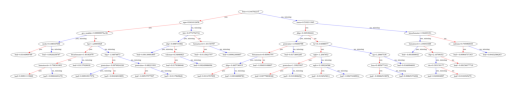

In [14]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

In [15]:
from shap import TreeExplainer
import shap
shap.initjs()

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


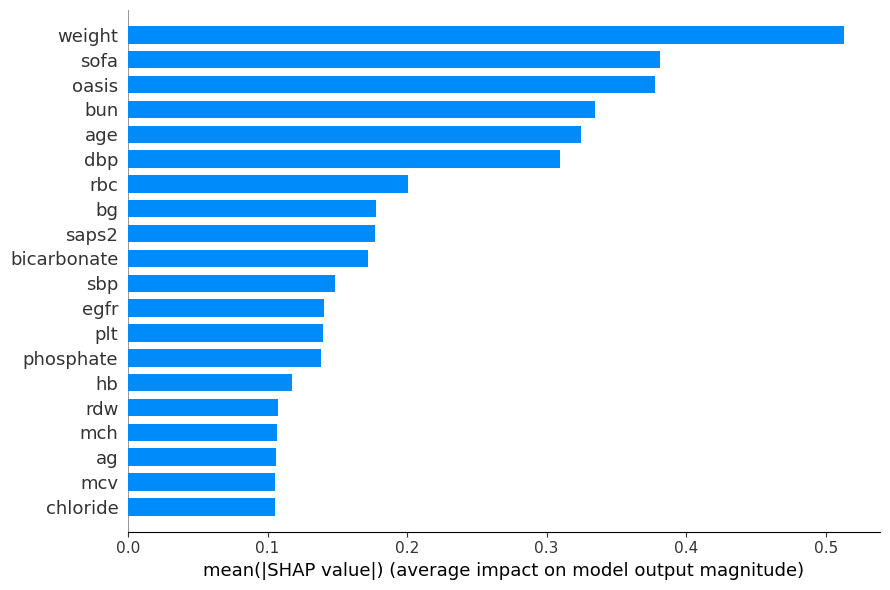

In [16]:
from constants import TEMP_PATH


expl = TreeExplainer(model)
shap_values = expl(X_test)

shap.summary_plot(shap_values, plot_type="bar", show=False, plot_size=[9, 6])
plt.savefig(TEMP_PATH / "shap_xgboost_summary_plot.svg", format="svg")
plt.show()

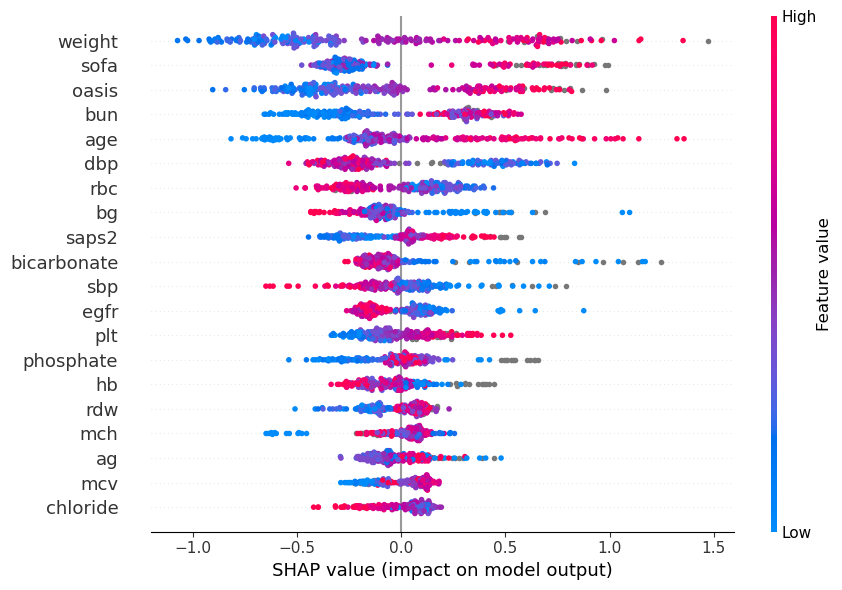

In [17]:
shap.summary_plot(shap_values, show=False, plot_size=[9, 6])
plt.savefig(TEMP_PATH / "shap_xgboost_beeswarm.svg", format="svg")
plt.show()